# 1. Initialize Spark Connect

In [ ]:
import os
from cde import CDESparkConnectSession

spark = CDESparkConnectSession.builder.sessionName('testying').get()


In [2]:
print(spark.version)

3.5.1.1.23.7218.0-28


# 2. Load Transaction Data

In [3]:

from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType
spark = CDESparkConnectSession.builder.sessionName('testying').get()

# Define the schema explicitly
schema = StructType([
    StructField("TransactionID", IntegerType(), True),
    StructField("Date", StringType(), True),
    StructField("CustomerName", StringType(), True),
    StructField("TransactionType", StringType(), True),
    StructField("Amount", FloatType(), True),  # Ensure Amount is float
    StructField("State", StringType(), True)
])

# Sample Bank Transaction Data
data = [
    (1, "2024-11-20", "Alice", "Credit", 500.00, "NY"),
    (2, "2024-11-20", "Bob", "Debit", 200.00, "CA"),
    (3, "2024-11-21", "Alice", "Debit", 100.00, "NY"),
    (4, "2024-11-21", "David", "Credit", 700.00, "TX"),
    (5, "2024-11-22", "Edward", "Debit", 150.00, "CA"),
    (6, "2024-11-22", "Alice", "Credit", 300.00, "NY"),
    (7, "2024-11-22", "Alice", "Credit", 300.00, "NY")  # Duplicate transaction
]

# Load data into a DataFrame with the schema
df = spark.createDataFrame(data, schema=schema)
df = df.withColumn("Amount",  df["Amount"].cast('float'))

print("Sample Bank Transaction Data:")
df.show()


Sample Bank Transaction Data:
+-------------+----------+------------+---------------+------+-----+
|TransactionID|      Date|CustomerName|TransactionType|Amount|State|
+-------------+----------+------------+---------------+------+-----+
|            1|2024-11-20|       Alice|         Credit| 500.0|   NY|
|            2|2024-11-20|         Bob|          Debit| 200.0|   CA|
|            3|2024-11-21|       Alice|          Debit| 100.0|   NY|
|            4|2024-11-21|       David|         Credit| 700.0|   TX|
|            5|2024-11-22|      Edward|          Debit| 150.0|   CA|
|            6|2024-11-22|       Alice|         Credit| 300.0|   NY|
|            7|2024-11-22|       Alice|         Credit| 300.0|   NY|
+-------------+----------+------------+---------------+------+-----+



# 3. Explore the Data

### Data Description

In [4]:
# Schema of the Data
print("Schema of the Data:")
df.printSchema()

# Summary Statistics
print("Summary Statistics:")
df.describe(["Amount"]).show()

Schema of the Data:
root
 |-- TransactionID: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- CustomerName: string (nullable = true)
 |-- TransactionType: string (nullable = true)
 |-- Amount: float (nullable = true)
 |-- State: string (nullable = true)

Summary Statistics:
+-------+------------------+
|summary|            Amount|
+-------+------------------+
|  count|                 7|
|   mean|321.42857142857144|
| stddev|211.85125060039744|
|    min|             100.0|
|    max|             700.0|
+-------+------------------+



### Aggregations by Transaction Type and State

In [5]:
# Step 1: Register DataFrame as a temporary SQL table
df.createOrReplaceTempView("transactions")

# Step 2: Total Transactions by Transaction Type using Spark SQL
total_transactions_query = """
SELECT TransactionType, COUNT(*) AS TotalTransactions
FROM transactions
GROUP BY TransactionType
"""

# Execute the query and show the result
total_transactions_df = spark.sql(total_transactions_query)
print("Total Transactions by Transaction Type:")
total_transactions_df.show()

# Step 3: Max Transaction Amount per State using Spark SQL
max_transaction_query = """
SELECT State, MAX(Amount) AS MaxTransactionAmount
FROM transactions
GROUP BY State
"""

# Execute the query and show the result
max_transaction_df = spark.sql(max_transaction_query)
print("Max Transaction Amount per State:")
max_transaction_df.show()

Total Transactions by Transaction Type:
+---------------+-----------------+
|TransactionType|TotalTransactions|
+---------------+-----------------+
|         Credit|                4|
|          Debit|                3|
+---------------+-----------------+

Max Transaction Amount per State:
+-----+--------------------+
|State|MaxTransactionAmount|
+-----+--------------------+
|   CA|               200.0|
|   NY|               500.0|
|   TX|               700.0|
+-----+--------------------+



In [6]:
# Check Spark version (indicates SparkSession is active)
try:
    print(f"Spark version: {spark.version}")
except NameError:
    print("SparkSession has not been initialized.")


Spark version: 3.5.1.1.23.7218.0-28


In [7]:
spark = CDESparkConnectSession.builder.sessionName('testying').get()

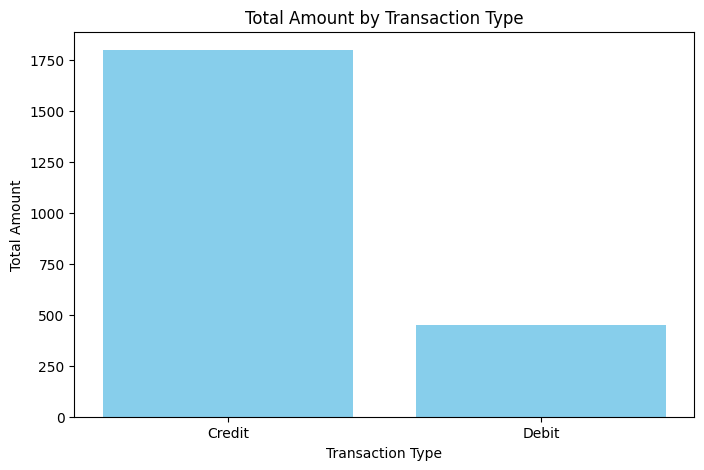

In [8]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum as _sum


# Aggregate data for visualization
df.createOrReplaceTempView("transactions")
agg_query = """
SELECT TransactionType, SUM(Amount) AS TotalAmount
FROM transactions
GROUP BY TransactionType
"""
agg_data = spark.sql(agg_query).collect()

# Prepare data for plotting
transaction_types = [row["TransactionType"] for row in agg_data]
total_amounts = [row["TotalAmount"] for row in agg_data]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(transaction_types, total_amounts, color="skyblue")
plt.title("Total Amount by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Total Amount")
plt.show()


# 4. Test ETL Pipelines

In [9]:
from pyspark.sql.functions import col

# Remove duplicate transactions
dedup_df = df.dropDuplicates()

# Filter transactions with Amount > 200
filtered_query = """
SELECT * 
FROM transactions
WHERE Amount > 200
"""

# Execute the SQL query and get the result as a DataFrame
filtered_df = spark.sql(filtered_query)

# Save the transformed data to a Parquet file
output_path = "output/transformed_bank_transactions.parquet"
filtered_df.write.mode("overwrite").parquet(output_path)

print(f"Transformed data saved to {output_path}")

Transformed data saved to output/transformed_bank_transactions.parquet


# 5. Show Final Transformed Data

In [10]:
# Show the final transformed data
print("Final Transformed Data:")
filtered_df.show()

Final Transformed Data:
+-------------+----------+------------+---------------+------+-----+
|TransactionID|      Date|CustomerName|TransactionType|Amount|State|
+-------------+----------+------------+---------------+------+-----+
|            1|2024-11-20|       Alice|         Credit| 500.0|   NY|
|            4|2024-11-21|       David|         Credit| 700.0|   TX|
|            6|2024-11-22|       Alice|         Credit| 300.0|   NY|
|            7|2024-11-22|       Alice|         Credit| 300.0|   NY|
+-------------+----------+------------+---------------+------+-----+



# 6. Stop Spark Session

In [11]:
# Stop the Spark session
spark.stop()
print("Spark Session Stopped.")


Spark Session Stopped.
